<a href="https://colab.research.google.com/github/AnnaPakir/mult/blob/main/mult_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация анимационных проектов

In [1]:
!pip install googletrans==3.1.0a0 -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.6 MB/s eta 0:00:00


In [2]:
!pip install pymorphy2 -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.7 MB/s eta 0:00:00


In [89]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

In [4]:
# загрузим необходимые билиотеки
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from googletrans import Translator, constants
from pprint import pprint
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from pymorphy2 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tqdm.notebook import tqdm  # обеспечим себе возможность следить за ходом работы лемматизации
tqdm.pandas()
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import (
    OrdinalEncoder,
     RobustScaler
)

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    f1_score,
    confusion_matrix
)
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Необходимые константы
RANDOM_STATE = 42
TEST_SIZE = 0.3

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Настройка параметров pandas для отображения всех столбцов
pd.set_option('display.max_columns', None)

# Настройка параметров pandas для отображения всех строк
pd.set_option('display.max_rows', None)

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [9]:
import warnings

warnings.filterwarnings('ignore')

## Загрузка данных

In [10]:
# загрузим датафрейм
data = pd.read_csv('/content/drive/MyDrive/train.csv', lineterminator='\n')

# проверяем
data.head(5)

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN


Признак | Описание
--- | ---
date | дата, когда ролик появился на ютубе
reel_name | название ролика
yt_reel_id | уникальный идентификационный ролик на YouTube
cartoon | название проекта, целевая переменная
url | ссылка на ролик (включает идентификатор)
text | текстовый фрагмент, включает название ролика и описание
seconds | длительность
is_shorts | вертикальные видеоролики длительность <60сек
broadcast | Лайвы, прямые эфиры
yt_channel_id | идентификатор ютуб-канала
yt_channel_name | название ютуб канала
yt_ch_url | ссылка на ютуб канал
yt_channel_type | тип канала (Мультфильмы, Детские, Блогеры, Короткометражки…)
flag_closed | ютуб канал закрыт, если 1
international | метка международных каналов, каналов на иностранном языке (переведенный контент)
language | язык

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


16 признаков, из них:
- 4 типа float, 3  из них по названию являются бинарными признаками, можно будет посмотреть на них ближе и, возможно, изменить тип.
- один признак с датой, нужно сменить тип столбца
- остальные признаки текстовые, нужно выделить из них признаки
- есть пропуски. Особенно много их в столбце с языком. При этом, при первоначальном просмотре видно, что отсутсвие пометки об языке не означает, что описание на русском языке. Возможно, стоит пересобрать данный столбец уже на основе анализа.    

## EDA

### Таргет

Выведем первые и последние 5 строк количества значений в таргете

In [12]:
display(data['cartoon'].value_counts()[:5])
display(data['cartoon'].value_counts()[-5:])

,count
cartoon,
none,78231
Маша и медведь,853
Говорящий Том,589
Буба,529
Кошечки собачки,437


,count
cartoon,
Бременские музыканты,6
Паровозики Чаттингтон,6
Цветняшки,6
Enchantimals (Эншантималс),4
Вспыш,3


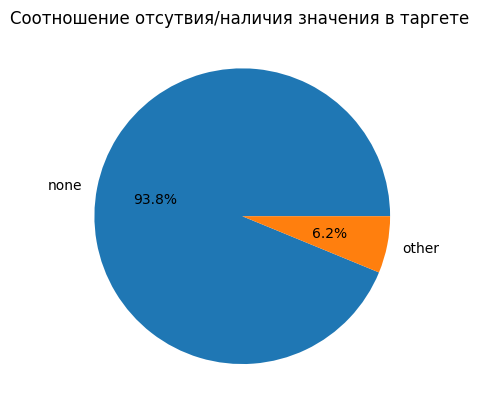

In [13]:
pd.DataFrame([data['cartoon'].value_counts().values[0],data['cartoon']
              .value_counts().values[1:].sum()], index=['none', 'other'])\
              .plot(kind='pie', autopct='%1.1f%%', subplots=True, legend=False)
plt.title('Соотношение отсутвия/наличия значения в таргете ')
plt.ylabel(' ')
plt.show()

Сильный дисбаланс данных в таргете. Строк со значениемми всго 6 процентов. Посмотрим на распределение строк с наличием значений в таргете.

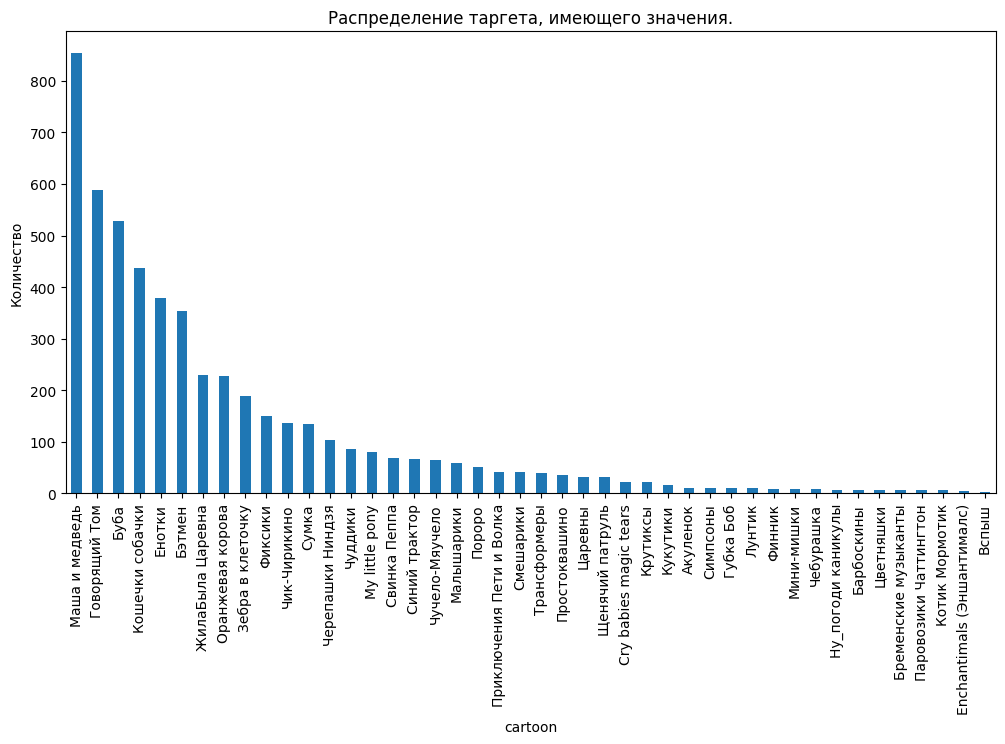

In [14]:
data[data['cartoon']!='none']['cartoon'].value_counts().plot(kind='bar', figsize=(12,6))
plt.title('Распределение таргета, имеющего значения.')
plt.ylabel('Количество')
plt.show()

Также виден дисбаланс данных. Есть категория с более 800 значений и категория всего с 3 значениями в таргете.

### Обработка дат

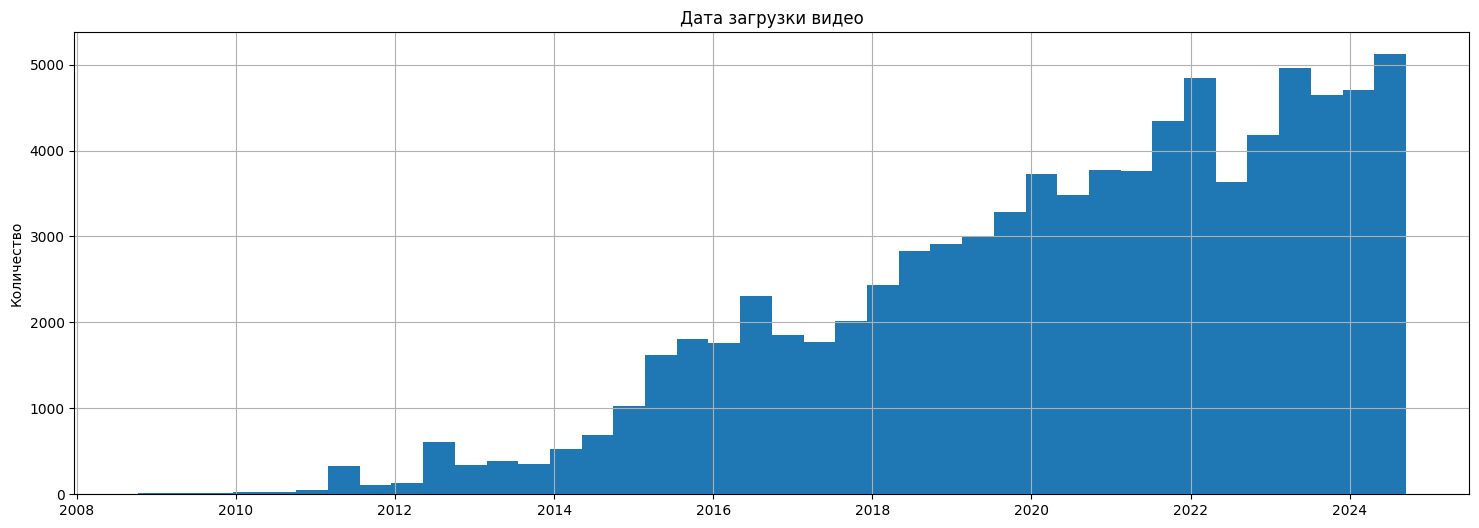

In [15]:
data['date']= pd.to_datetime(data['date'])
#data['date']= data['date'].apply(lambda x: x.date())

#выведем график
data['date'].hist(bins=40, figsize=(18,6))
plt.title('Дата загрузки видео')
plt.ylabel('Количество')
plt.show()

Данные с 2008 по 2024 год. Избавимся от точных значений(дат)

In [16]:
dat = pd.to_datetime('2008-01-01')
data['date']= data['date']-dat
data['date'] = data['date'].apply(lambda x: x.days)

### Числовой признак

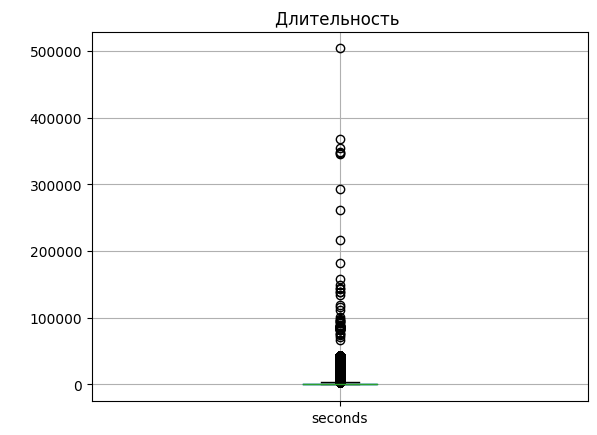

In [17]:
#выведем график
data['seconds'].to_frame().boxplot()
plt.title('Длительность ')
plt.ylabel(' ')
plt.show()

Много роликов довольно длительных. Почти 140 часов видео. Возможно, это сборники. Можно просмотреть на значение ближе

In [18]:
data[data['seconds']>300000]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
4253,5830,МиМиМишки Все серии подряд Kedoo мультики ...,ru-Gxl1efxQ,none,https://www.youtube.com/watch?v=ru-Gxl1efxQ,[МиМиМишки Все серии подряд Kedoo мультики...,345766.0,0.0,none,UCwMABIDNcqe2GS_Sm2jHKGg,KEDOO МУЛЬТИКИ для детей,https://www.youtube.com/channel/UCwMABIDNcqe2G...,Мультфильмы,0.0,0.0,NaN
15382,5711,МиМиМишки Все серии подряд Kedoo мультики ...,E0ddnUeG-aA,none,https://www.youtube.com/watch?v=E0ddnUeG-aA,[МиМиМишки Все серии подряд Kedoo мультики...,504055.0,0.0,none,UCwMABIDNcqe2GS_Sm2jHKGg,KEDOO МУЛЬТИКИ для детей,https://www.youtube.com/channel/UCwMABIDNcqe2G...,Мультфильмы,0.0,0.0,NaN
28385,5811,Baby balloons and more Meow Meow Kitty lessons,TJe_iwc8Wng,none,https://www.youtube.com/watch?v=TJe_iwc8Wng,[Baby balloons and more Meow Meow Kitty lesson...,367863.0,0.0,none,UClZkHt2kNIgyrTTPnSQV3SA,Get Movies,https://youtube.com/channel/UClZkHt2kNIgyrTTPn...,Мультфильмы,0.0,0.0,NaN
37630,5748,МиМиМишки Все серии подряд Kedoo мультики ...,g63UuzUl5YA,none,https://www.youtube.com/watch?v=g63UuzUl5YA,[МиМиМишки Все серии подряд Kedoo мультики...,349056.0,0.0,none,UCwMABIDNcqe2GS_Sm2jHKGg,KEDOO МУЛЬТИКИ для детей,https://www.youtube.com/channel/UCwMABIDNcqe2G...,Мультфильмы,0.0,0.0,NaN
54775,5740,МиМиМишки Все серии подряд Kedoo мультики ...,XGjtB2P5u6k,none,https://www.youtube.com/watch?v=XGjtB2P5u6k,[МиМиМишки Все серии подряд Kedoo мультики...,354048.0,0.0,none,UCwMABIDNcqe2GS_Sm2jHKGg,KEDOO МУЛЬТИКИ для детей,https://www.youtube.com/channel/UCwMABIDNcqe2G...,Мультфильмы,0.0,0.0,NaN
61290,5760,МиМиМишки Все серии подряд Kedoo мультики ...,oGrhv3hnznU,none,https://www.youtube.com/watch?v=oGrhv3hnznU,[МиМиМишки Все серии подряд Kedoo мультики...,347302.0,0.0,none,UCwMABIDNcqe2GS_Sm2jHKGg,KEDOO МУЛЬТИКИ для детей,https://www.youtube.com/channel/UCwMABIDNcqe2G...,Мультфильмы,0.0,0.0,NaN


В основном сборники всех серий Мимимишек. Значения вполне реальные. Посмотрим нулевые значения.

In [19]:
data[data['seconds']<1]['seconds'].count()

1766

In [20]:
data[data['seconds']==0]['broadcast'].value_counts()

,count
broadcast,
live,1682
upcoming,84


Видео с лайвов и прямых эфиров показывают нулевую длительность.

### Категориальные и бинарные значения.

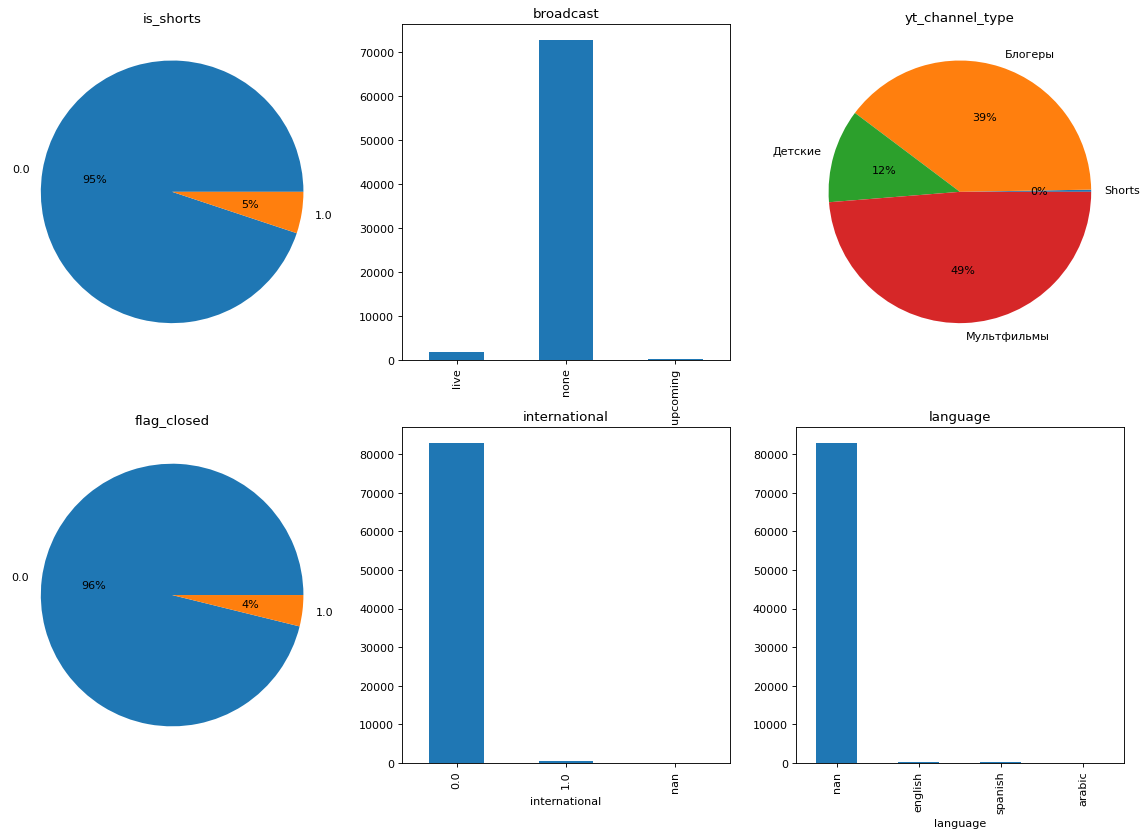

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12), dpi=80)
data.pivot_table(index='is_shorts', values='url', aggfunc='count').plot(kind='pie',autopct='%1.0f%%', subplots=True, ax= ax[0,0], legend=False)
ax[0,0].set_title('is_shorts')
ax[0,0].set_ylabel('')
data.pivot_table(index='broadcast', values='url', aggfunc='count').plot(kind='bar', subplots=True, legend=False,ax=ax[0,1])
ax[0,1].set_title('broadcast')
ax[0,1].set_ylabel('')
data.pivot_table(index='yt_channel_type', values='url', aggfunc='count').plot(kind='pie',autopct='%1.0f%%', subplots=True, ax= ax[0,2], legend=False)
ax[0,2].set_title('yt_channel_type')
ax[0,2].set_ylabel('')
data.pivot_table(index='flag_closed', values='url', aggfunc='count').plot(kind='pie',autopct='%1.0f%%', subplots=True, ax= ax[1,0], legend=False)
ax[1,0].set_title('flag_closed')
ax[1,0].set_ylabel('')
data['international'].value_counts(dropna= False).plot(kind='bar', subplots=True, ax= ax[1,1], legend=False)
ax[1,1].set_title('international')
ax[1,1].set_ylabel('')
data['language'].value_counts(dropna=False).plot(kind='bar', subplots=True, ax= ax[1,2], legend=False)
ax[1,2].set_title('language')
ax[1,2].set_ylabel('')
plt.show()

Дисбаланс данных в признаках. Посмотрим на некотрые признаки более внимательно.

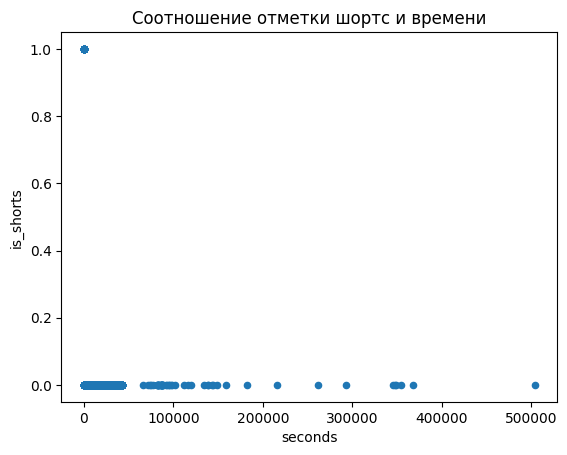

In [22]:
data.plot(x='seconds', y='is_shorts', kind= 'scatter')
plt.title('Соотношение отметки шортс и времени')
plt.show()

In [23]:
print('Количество видео с отметкой шортс, длинее 60 сек: ', data[(data['seconds']>60) &(data['is_shorts']==1)]['reel_name'].count())
print('Количество видео без отметки шортс, меньше 60 сек: ', data[(data['seconds']<60) &(data['is_shorts']==0)]['reel_name'].count())

Количество видео с отметкой шортс, длинее 60 сек:  0
Количество видео без отметки шортс, меньше 60 сек:  5627


In [24]:
data[(data['seconds']<60) &(data['is_shorts']==0)][:3]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
16,5822,Сеня Ездит на ОГРОМНОМ МОНСТРТРАКЕ по ИГРУШКАМ,BAAgv90iK-w,none,https://www.youtube.com/watch?v=BAAgv90iK-w,[Сеня Ездит на ОГРОМНОМ МОНСТРТРАКЕ по ИГРУШКА...,0.0,0.0,live,UCTn9Vyy-3fzLIr0bqhIbNig,Super Senya RU,https://www.youtube.com/channel/UCTn9Vyy-3fzLI...,Блогеры,0.0,0.0,NaN
62,6002,New music funny,erdsFZUfGQY,none,https://www.youtube.com/watch?v=erdsFZUfGQY,[New music funny],44.0,0.0,none,UC0UecwriAVVm0gyyEFpakDQ,SuperSofi,https://youtube.com/channel/UC0UecwriAVVm0gyyE...,Блогеры,0.0,0.0,NaN
81,5194,Алиса и большая подушка,_kkQ1YOPHz4,none,https://www.youtube.com/watch?v=_kkQ1YOPHz4,[Алиса и большая подушка ] Алиса купила большу...,8.0,0.0,none,UCsIoBmCIpp62ikGuXA_4SoQ,Alice Mimi Lissa,https://youtube.com/channel/UCsIoBmCIpp62ikGuX...,Блогеры,0.0,0.0,NaN


Просто короткие видео не включены в понятие шортс.

In [25]:
display(data.pivot_table(index=['language','international'], values='url', aggfunc='count'))
display(data.pivot_table(index=['international', 'language',], values='url', aggfunc='count'))

,,url
language,international,
arabic,1.0,92
english,1.0,204
spanish,1.0,201


url
international language     
1.0           arabic     92
              english   204
              spanish   201

Признак языка совпадает с меткой языка

In [26]:
data[data['international']==1]['cartoon'].value_counts(dropna=False)

,count
cartoon,
Енотки,327
Оранжевая корова,170


Откровенно говоря, сильная учетка данных. Если делать модель, способную дообучатся, это признак должен быть удален (модель выучит, что если есть отметка о языке, то это или Енотки или Оранжевая корова. Сейчас, в рамках соревновая признак может быть оставлен)

In [27]:
print('Количество уникальных значений:', data['yt_channel_name'].nunique())
display(data['yt_channel_name'].value_counts()[:5])
display(data['yt_channel_name'].value_counts()[-5:])

Количество уникальных значений: 203


,count
yt_channel_name,
Kedoo Toons TV Funny Animations,2442
Guka Family Show,2264
Теремок ТВ,2137
Super Senya RU,1767
Get Movies,1654


,count
yt_channel_name,
Паровозики из Чаггингтона,3
Буба #Shorts,2
Тайны медовой долины,2
Свинка Пеппа Русский Официальны,1
Царевны,1


### Просмотр пропусков

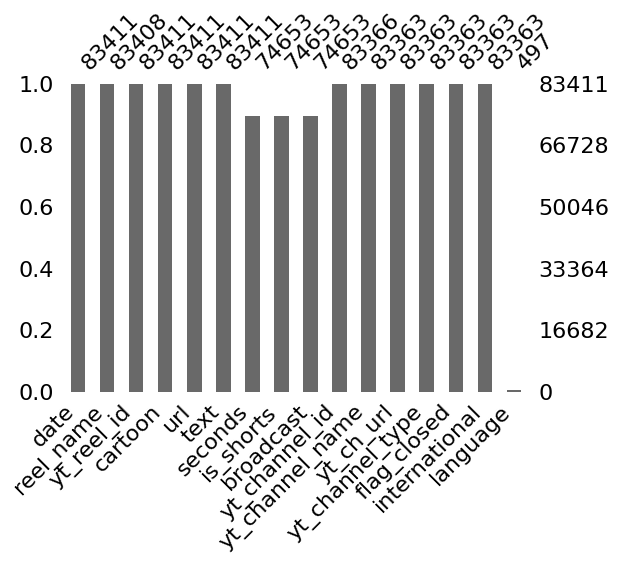

In [28]:
msno.bar(data, figsize = (6,4))
plt.show()

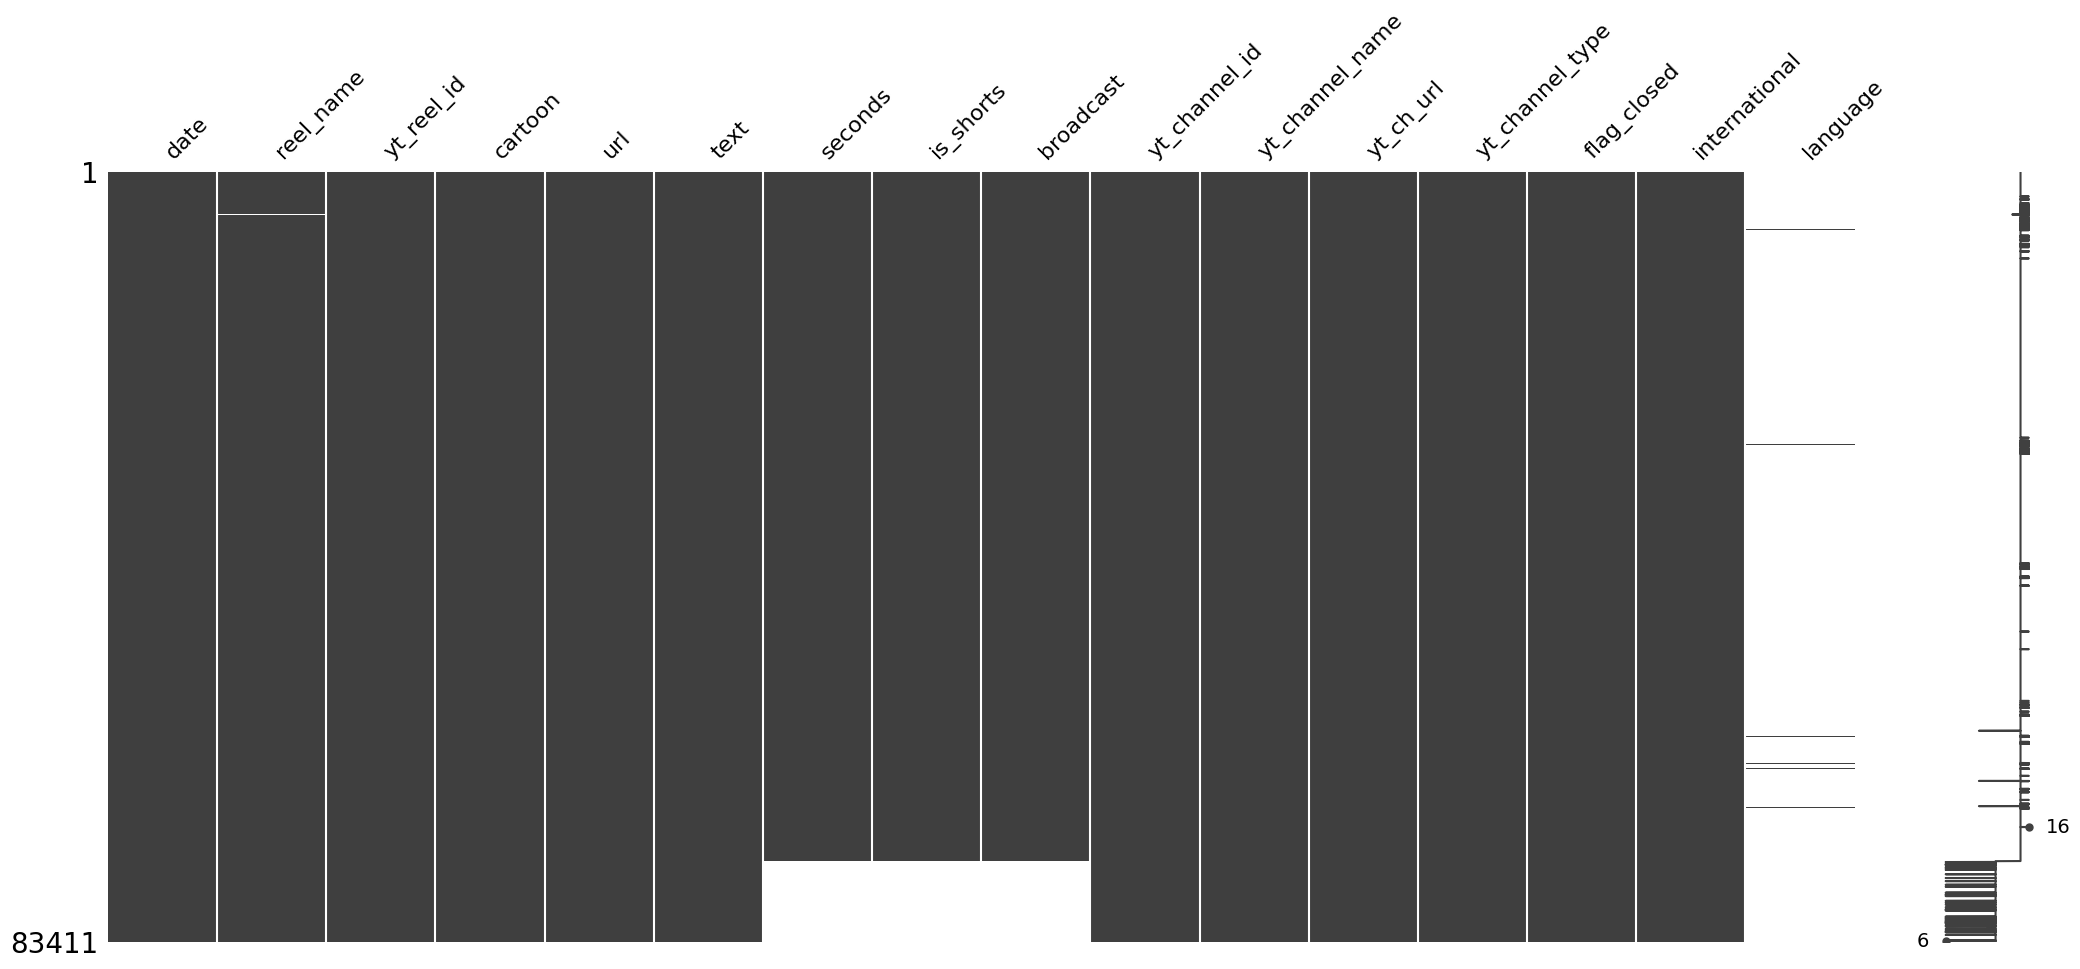

In [29]:
msno.matrix(data.sort_values('seconds'))
plt.show()

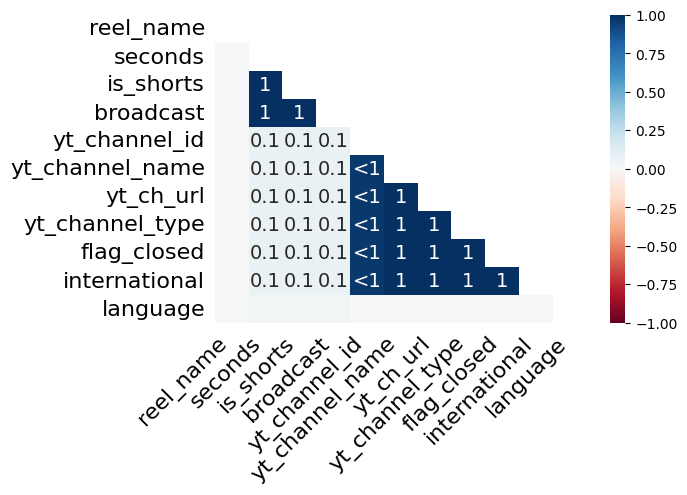

In [30]:
msno.heatmap(data, figsize = (6,4))
plt.show()

Пропуски в большинстве столбцов совпадают. Прсмотрим ближе данные с пропусками

In [31]:
data[data['reel_name'].isna()]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
15331,6094,NaN,_S1ro6h6Ils,none,https://www.youtube.com/watch?v=_S1ro6h6Ils,[],19.0,0.0,none,UCfBtfDbuAH6tZnb-Q9EzauA,LEV family SHOW RUS,https://youtube.com/channel/UCfBtfDbuAH6tZnb-Q...,Блогеры,0.0,0.0,NaN
17756,5487,NaN,daJ0drzcYz4,none,https://www.youtube.com/watch?v=daJ0drzcYz4,[] shorts shortsviral babyalive deixaolike],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN
66766,5425,NaN,Zu_vwE48tqI,none,https://www.youtube.com/watch?v=Zu_vwE48tqI,[] shortsviral babyalive babyalive brincadeira],NaN,NaN,NaN,UCUT1XWGIx6MxWmtPsGYcBEg,Bush Baby World Пушастики,https://www.youtube.com/channel/UCUT1XWGIx6MxW...,Мультфильмы,0.0,0.0,NaN


### Текстовые данные

In [32]:
data['text'].unique()[:5]

array(['[100 подарков и только один можно оставить себе] ',
       '[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ Follow Me] ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ Follow Mehttps://youtu.be/Lcp0pFZF4eQ',
       '[Грозная семейка  Лучшие СЕСТРИНСКИЕ моменты  с Хлои, Фиби и Норой в "Опасная семейка"] Девочки Сандермен  сплочённая команда сестёр и супергероев, что всегда вместе Фиби, Хлои и Норе Сандермен весело вместе, когда они спасают мир или просто зависают дома Черепашкининдзя никелодеон никелодеонроссия HenryDanger Nickelodeon NickelodeonCyrillic РоссияПривіт Ласкаво просимо на офіційний канал Nickelodeon на ютубі Тут ти знайдеш повні випуски улюблених шоу українською мовою у високій якості. Мультсеріали Черепашкиніндзя, Губка Боб Квадратні Штани, Гучний дім, Хлібокачки та багато інших чекають тебе на нашому youtubeканалі',
       '[Как сделать ожерелье из ткани своими руками] Как сделать стильное ожерелье своими руками В этом мастерклассе мы предлагаем создать нежное цветочно

Удалим части с ссылками с помощью функции find. Функция find если не находит слова, то оставляет последнюю букву из строки, поэтому, объединим значения.

In [33]:
def exo(line):
  if len(line['text_1'])>2:
    return line['text_1']
  else:
    return line['text']

In [34]:
data['text_1'] = data['text'].apply(lambda x: x[:x.find('https')])

data['text_1'] = data.apply(exo, axis=1)
data['text_1'].unique()[:5]

array(['[100 подарков и только один можно оставить себе]',
       '[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ Follow Me] ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ Follow Me',
       '[Грозная семейка  Лучшие СЕСТРИНСКИЕ моменты  с Хлои, Фиби и Норой в "Опасная семейка"] Девочки Сандермен  сплочённая команда сестёр и супергероев, что всегда вместе Фиби, Хлои и Норе Сандермен весело вместе, когда они спасают мир или просто зависают дома Черепашкининдзя никелодеон никелодеонроссия HenryDanger Nickelodeon NickelodeonCyrillic РоссияПривіт Ласкаво просимо на офіційний канал Nickelodeon на ютубі Тут ти знайдеш повні випуски улюблених шоу українською мовою у високій якості. Мультсеріали Черепашкиніндзя, Губка Боб Квадратні Штани, Гучний дім, Хлібокачки та багато інших чекають тебе на нашому youtubeканал',
       '[Как сделать ожерелье из ткани своими руками] Как сделать стильное ожерелье своими руками В этом мастерклассе мы предлагаем создать нежное цветочное ожерелье из нескольких видов

In [35]:
# удалим квадратные скобки
data['text_1'] = data['text_1'].apply(lambda x: x.replace('[',''))
data['text_1'] = data['text_1'].apply(lambda x: x.replace(']',''))

Создадим столбец, явно указывающий на язык текста.

In [36]:
def alfa(x):
  for i in alfav:
    if i in x.lower():
      return 1
  return 0

In [37]:
alfav = list('бвгджлпуфцчшщыэюя')


data['lg'] = data['text_1'].apply(alfa)
data['lg'].value_counts()

,count
lg,
1,68658
0,14753


Для перевода строк с наличием иных языков разделим датафрейм на две части и произведем обработку.

In [38]:
data_2 = data[data['lg']==0].copy()
data_2 =data_2.reset_index(drop=True)
data_2.shape

(14753, 18)

In [39]:
data_2['text_1'] = data_2['text_1'].apply(lambda x: 'no' if len(x)<2 else x)

In [40]:
translator = Translator()

In [42]:
j =0
data_f = pd.DataFrame(columns= data_2.columns)
for i in range(500,14501,500):
  data_a = data_2[j:i]
  data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
  data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x, dest='ru').text)
  data_f=pd.concat([data_f, data_a])
  print(data_f.shape)
  j=i

(500, 18)
(1000, 18)
(1500, 18)
(2000, 18)
(2500, 18)
(3000, 18)
(3500, 18)
(4000, 18)
(4500, 18)
(5000, 18)
(5500, 18)
(6000, 18)
(6500, 18)
(7000, 18)
(7500, 18)
(8000, 18)
(8500, 18)
(9000, 18)
(9500, 18)
(10000, 18)
(10500, 18)
(11000, 18)
(11500, 18)
(12000, 18)
(12500, 18)
(13000, 18)
(13500, 18)
(14000, 18)
(14500, 18)


In [43]:
data_a = data_2[j:]
data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x, dest='ru').text)
data_f=pd.concat([data_f, data_a])
data_f.shape

(14753, 18)

In [44]:
data_2 = data[data['lg']==1].copy()
data_2.shape
data = pd.concat([data_2,data_f])
data.shape

(83411, 18)

Переведем также столбец с имененм канала

In [45]:
data['yt_channel_name'] = data['yt_channel_name'].fillna('нет')

In [46]:
j =0
data_f = pd.DataFrame(columns= data.columns)
for i in range(500,83001,500):
  data_a = data[j:i]
  data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
  data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x, dest='ru').text)
  data_f=pd.concat([data_f, data_a])
  if i%2000==0:
      print(data_f.shape)
  j=i

(2000, 18)
(4000, 18)
(6000, 18)
(8000, 18)
(10000, 18)
(12000, 18)
(14000, 18)
(16000, 18)
(18000, 18)
(20000, 18)
(22000, 18)
(24000, 18)
(26000, 18)
(28000, 18)
(30000, 18)
(32000, 18)
(34000, 18)
(36000, 18)
(38000, 18)
(40000, 18)
(42000, 18)
(44000, 18)
(46000, 18)
(48000, 18)
(50000, 18)
(52000, 18)
(54000, 18)
(56000, 18)
(58000, 18)
(60000, 18)
(62000, 18)
(64000, 18)
(66000, 18)
(68000, 18)
(70000, 18)
(72000, 18)
(74000, 18)
(76000, 18)
(78000, 18)
(80000, 18)
(82000, 18)


In [47]:
data_a = data[j:]
data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x, dest='ru').text)
data_f=pd.concat([data_f, data_a])
data_f.shape

(83411, 18)

In [48]:
data = data_f.copy()

In [49]:
data['text_1'] = data['text_1']+' '+data['yt_channel_name']

In [51]:
def token(text):
  '''
  Функция оставляет в строке только буквы
  '''
  pattern = r'[А-ЯЁ]{2,15}'
  text_2 = re.compile(pattern, re.IGNORECASE).findall(text)

  return text_2

In [52]:
for doc in tqdm(range(100)):
    data['text_2'] = data['text_1'].apply(lambda x: token(x))
data.head()

  0%|          | 0/100 [00:00<?, ?it/s]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,text_1,lg,text_2
0,5842,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Мисс Кэти,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN,100 подарков и только один можно оставить себе...,1,"[подарков, только, один, можно, оставить, себе..."
1,3832,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Мальчики и игрушки,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,1,"[ЗАБАГАЛИ, Лизу, Реальной, Жизни, АРТУР, НАСТЯ..."
2,5808,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Кириллица,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,1,"[Грозная, семейка, Лучшие, СЕСТРИНСКИЕ, момент..."
3,3072,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN,Как сделать ожерелье из ткани своими руками Ка...,1,"[Как, сделать, ожерелье, из, ткани, своими, ру..."
5,5780,Лекс и Плу Сборник замечательных серий Мульт...,WaGIOXW8UT4,none,https://www.youtube.com/watch?v=WaGIOXW8UT4,[Лекс и Плу Сборник замечательных серий Муль...,3655.0,0.0,none,UC74c-dgIRPIucT88Bq0zFHg,Лекс и Плу,https://youtube.com/channel/UC74c-dgIRPIucT88B...,Мультфильмы,0.0,0.0,NaN,Лекс и Плу Сборник замечательных серий Мульт...,1,"[Лекс, Плу, Сборник, замечательных, серий, Мул..."


In [53]:
def token_2(text):
  '''
  Функция лематизирует и удадает стоп-слова
  '''

  token_2 = []
  for i in text:
    s = morph.normal_forms(i)[0]
    token_2.append(s)
  text_3 =  [token.lower() for token in token_2 if token.lower() not in stopwords.words('russian')]

  return text_3

In [54]:
morph = MorphAnalyzer()

In [55]:
j =0
data_f = pd.DataFrame(columns= data.columns)
for i in range(500,83001,500):
  data_a = data[j:i]
  data_a['text_2'] = data_a['text_2'].apply(lambda x: token_2(x))
  data_f=pd.concat([data_f, data_a])
  if i%4000==0:
      print(data_f.shape)
  j=i


(4000, 19)
(8000, 19)
(12000, 19)
(16000, 19)
(20000, 19)
(24000, 19)
(28000, 19)
(32000, 19)
(36000, 19)
(40000, 19)
(44000, 19)
(48000, 19)
(52000, 19)
(56000, 19)
(60000, 19)
(64000, 19)
(68000, 19)
(72000, 19)
(76000, 19)
(80000, 19)


In [56]:
data_a = data[j:]
data_a['text_2'] = data_a['text_2'].apply(lambda x: token_2(x))
data_f=pd.concat([data_f, data_a])

In [57]:
data_f.shape

(83411, 19)

In [58]:
data = data_f.copy()

In [59]:
data['text_2'] = data['text_2'].apply(lambda x: ' '.join(x))

In [60]:
data = data[['date','seconds', 'is_shorts', 'broadcast','yt_channel_type',
       'flag_closed', 'international', 'text_2', 'cartoon']]
data.head()

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2,cartoon
0,5842,1854.0,0.0,none,Блогеры,0.0,0.0,подарок оставить мисс кэти,none
1,3832,602.0,0.0,none,Блогеры,0.0,0.0,забагали лиза реальный жизнь артур настя забаг...,none
2,5808,3604.0,0.0,none,Мультфильмы,0.0,0.0,грозный семейка хороший сестринский момент хло...,none
3,3072,264.0,0.0,none,Блогеры,0.0,0.0,сделать ожерелие ткань свой рука сделать стиль...,none
5,5780,3655.0,0.0,none,Мультфильмы,0.0,0.0,лекс плу сборник замечательный серия мультфиль...,none


In [61]:
list_object = ['is_shorts', 'flag_closed', 'international']
data[list_object] = data[list_object].astype('object')

In [62]:
data['is_shorts'] = data['is_shorts'].apply(lambda x:str(x))
data['flag_closed'] = data['flag_closed'].apply(lambda x:str(x))
data['international'] = data['international'].apply(lambda x:str(x))

In [63]:
data['is_shorts'] = data['is_shorts'].apply(lambda x:None if x=='nan' else x)
data['flag_closed'] = data['flag_closed'].apply(lambda x:None if x=='nan' else x)
data['international'] = data['international'].apply(lambda x:None if x=='nan' else x)

In [64]:
data['broadcast'] = data['broadcast'].apply(lambda x:None if x=='none' else x)
data['yt_channel_type'] = data['yt_channel_type'].apply(lambda x:None if x=='Shorts' else x)

## Моделирование

#### Baseline

In [65]:
# Выделение из датафрейма общего набора признаков и целевого
target = data['cartoon']
features = data.drop(['cartoon'], axis =1)

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
        features, target,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE,
        stratify=target)

In [66]:
label = LabelEncoder()
y_train_new = label.fit_transform(y_train)
y_test_new = label.transform(y_test)

In [67]:
num_columns = ['seconds', 'date']
cat_columns = ['is_shorts','broadcast', 'yt_channel_type','flag_closed', 'international']
text_columns = ['text_2']

pipe_num = Pipeline(
    [
        ('inputer',SimpleImputer(strategy='constant',fill_value=0)),
        ('scaler', RobustScaler())
    ]
    )

pipe_cat = Pipeline(
    [
        ('inputer', SimpleImputer(strategy='constant',fill_value='no')),
        ('scaler', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]
    )


data_preprocessor = ColumnTransformer(
          [('num', pipe_num, num_columns),
          ('cat', pipe_cat, cat_columns),
          ('text', CountVectorizer(), 'text_2')],
    remainder = 'passthrough'
    )

pipe_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  LGBMClassifier(random_state=RANDOM_STATE,  verbose=-1))
])

param_grid = [ {'models': [LGBMClassifier(random_state=RANDOM_STATE,  verbose=-1)],}]
     #            'models__num_leaves': range(14, 15),
     #            'models__max_depth': range(7, 8),
     #            'models__n_estimators': range(90, 91,10)}]


search = GridSearchCV(pipe_lgbm, param_grid, cv=2, scoring='f1_macro', error_score='raise', n_jobs=-1)
search.fit(X_train, y_train_new)

print('Best model:', search.best_params_)
print('Best_score', search.best_score_)

Best model: {'models': LGBMClassifier(random_state=42, verbose=-1)}
Best_score 0.034488056143167814


In [68]:
y_test_pred = search.predict(X_test)
print('Метрики на тестовых данных:')
print('f1_macro:', round(f1_score(y_test_new, y_test_pred, average='macro'),3))

Метрики на тестовых данных:
f1_macro: 0.021


Маленькая метрика, нужно попробовать что-нибудь другое

#### Дополнительная обработа

Добавим в часть обучающей выборки новые данные. В свящи с тем, что мы не знаем о том, как могли подписать каждый мультфильм под роликом, имеет смысл добавить в текстровое описание кроткое описание сужета, а также персожажей и их имена.

In [69]:
text = {('none','нет'),
        ('Смешарики','Истории о дружбе и приключениях обаятельных круглых героев. Целый мир в одной уютной ромашковой долине.В сериале представлены герои трёх возрастных групп — дети-подростки (Крош, Ёжик, Нюша, Бараш), взрослые (Лосяш, Пин), и пожилые (Кар Карыч, Совунья, Копатыч)'),
        ('Кошечки собачки','В небольшом самом обыкновенном городке, с самыми необычными достопримечательностями, живут кошки и собаки. У каждой семьи есть необычный дом, в котором работают. Каждая семья владеет своим бизнесом и занята своим делом.И только шесть юных непосед нарушают размеренную жизнь города — две кошечки Алиса и Буся и четыре собачки: Мия, Жоржик, Викки и Дэн.'),
        ('Зебра в клеточку','Музыкальный мультсериал про весёлые приключения зверят на тропическом острове. Центральный персонаж — очень необычная зебра, Зебра в клеточку, которая родилась в джунглях у полосатых мамы и папы и которая, по всей видимости, даже не настоящая зебра, о чем ей в открытую говорят соплеменники.Главные герои мультсериала, обезьянка Яна, зебры Клеточка и Поля, крокодил Гоша, слон Родион и страус Паша с братом яйцом Петей, живут на острове.'),
        ('Сумка','Веселый развивающий мультфильм о девочке Смарте, которая хочет все знать и уметь. В ее чудо-сумочке есть куча полезных вещичек – от навигатора и смартфона до английского словарика. Смарта вместе со своим верным другом, собачкой-сладкоежкой Спотти, будет придумывать и выполнять разные интересные задания, петь забавные песенки, разучивать считалочки и учиться считать, знакомиться с английским языком и правилами дорожного движения. Смарта, Спотти, Хэй — навигатор, Вики — энциклопедия, Калки — калькулятор, Токи — словарь, Амалия'),
        ('Фиксики','Мультсериал рассказывает о приключениях маленьких человечков — фиксиков, которые живут внутри различных приборов и техники, содержат её в порядке и отлично знают, что и как устроено. Си́мка, Но́лик, Па́пус, Ма́ся, Де́дус, Фа́йер, И́грек, Шпу́ля, Ве́рта,  Альт, Фрик и Гик  ДимДи́мыч (Дмитрий Дмитриевич Кудыкин) Гений Евгеньевич Чудаков Кусачка Жучка'),
        ('Черепашки Ниндзя','Черепашки-ниндзя – вымышленные персонажи по мотивам комиксов художников Кевина Истмена и Питера Лэрда. Юные мутанты черепашки-ниндзя, овладевших искусством восточных единоборств. Черепашки живут в канализации Нью-Йорка вместе со своим сэнсеем, крысой-мутантом Сплинтером, и сражаются со злодеями, начиная с обычных гангстеров и заканчивая инопланетными захватчиками. Леонардо, Донателло, Рафаэлем и МикеланджелоИрма Лангинштейн Эйприл Нил Хамато Сплинтер'),
        ('ЖилаБыла Царевна','Царевна, Царевич, Царь и Царица. Добрый мультфильм про очаровательную рыжую царевну с самым обычным непослушным нравом.'),
        ('My little pony','Спайк, Эпплджек, Радуга Дэш, Рэйнбоу Дэш, Пинки Пай, Рарити, Рэрити, Флаттершай. Главная героиня — единорог (аликорн) по имени Сумеречная Искорка, ученица принцессы Селестии, которая всё время сидела за книгами и не желала ни с кем общаться. Видя, как героиня зарылась с головой в учёбу, принцесса даёт ей задание найти друзей и отправляет Искорку и её ассистента, дракона по имени Спайк, в Понивилль. Там она встречает разных пони, своих новых друзей: задиристую Радугу Дэш, элегантную Рарити, трудолюбивую Эпплджек, робкую Флаттершай и гипер-активную Пинки Пай.'),
        ('Чик-Чирикино','Папа Аркадий · Настя · Рома · Виталий Петрович · Боря · Василиса · Алина. Чик-Чирикино — городок, похожий на человеческий. Но живут в нем птицы, которые, как и люди, ходят на работу и в школу, путешествуют на автомобилях и гуляют в парках. В городке пернатых обитает и многодетная воробьиная семья Чирикиных, главных героев мультсериала.'),
        ('Царевны','Царевна Варвара-Краса Длинная Коса, Василиса Царевна-Лягушка, Дарья – Царевна-Несмеяна, Царевна Елена Прекрасная и Спящая Царевна Соня. Сериал рассказывает о приключениях пяти девочек-царевен, приехавших из разных царств-государств обучаться в школе волшебства Дивногорье. В школе ведут уроки трое учителей: Кощей Бессмертный, Кот-Баюн, Марлен. Учащиеся познают не только науки, но и волшебные заклинания.'),
        ('Котик Мормотик','Как и многие братья и сестры, Гоша и Юля часто ссорятся по пустякам: то мальчик испортит ее рисунок, то девочка уронит его любимую машинку. Для сохранения хороших отношений им просто необходим волшебный помощник. Так из старых лоскутов и появляется на свет Котик Мормотик. Он становится самым преданным другом для Гоши и Юли, ищет с ними потерянные игрушки и учит детей быть заботливыми и внимательными'),
        ('Малышарики','Пандочка Крошик Нюша Барашик Ёжик Пандочка Крошик. Малышарики. Герои живут и играют в человеческой квартире, кажущейся крошкам целым миром. Помимо обыкновенных предметов «людского» размера, в квартире можно найти и соразмерные малышарикам вещи, например, крохотные качели или кораблик. В этом детском мире реальность пересекается с воображением, и там можно найти даже море, раскинувшееся посреди письменного стола.'),
        ('Буба',' мышка Лула, попугай Гуга, ежик Спайк и червячок Дуда. Буба. Любопытный домовой ежеминутно находит приключения на свою седую голову. Неизвестно, откуда появился игривый, любознательный и загадочный Буба. Но он, очевидно, пропустил последние 100 лет эволюции человечества и только начинает исследовать современный мир.'),
        ('Синий трактор','Главным персонажем сериала является Синий Трактор - колёсный трактор синего цвета. У Синего Трактора есть прицеп, на котором он возит грузы, животных. В мультфильме другие тракторы, а также машинки, грузовики, строительная техника и другие герои рассказывают малышам познавательные истории: про цвета, как считать, как работают разные машины, как называются разные животные, какие у них привычки и особенности, какие звуки они издают, для чего существуют разные предприятия. Среди главных персонажей сериала — Профессор Кислых Щей, своей внешностью напоминающий учёного-физика Альберта Эйнштейна.'),
        ('Чучело-Мяучело','Музыкальный мультфильм про маленького, весёлого проказника — черного котенка по прозвищу Чучело-Мяучело, который любит петь по настроению когда просыпается'),
        ('Говорящий Том','Говорящий Том Говорящая Анджела Говорящий Джинджер Говорящий Бен Говорящий Хэнк Говорящая Бекка Мультсериал «Минимульты Говорящий Том представляет собой серию коротких мультфильмов, созданных на основе популярной игры «Мой Говорящий Том». Сюжет вращается вокруг кота Тома, который живет в виртуальном мире, где он может взаимодействовать с другими персонажами и выполнять различные задания. Он может играть в мини-игры, решать головоломки, собирать предметы и многое другое.'),
        ('Маша и медведь','Девочка Маша случайно оказывается в доме Медведя, живущего неподалёку от её дома, и устраивает там беспорядок. Медведь, находясь в ужасе от учинённого беспорядка и поведения незваной гостьи, пытается избавиться от неё, оставив в лесу. Маща приходит к Медведю в гости, постоянно шалит и устраивает беспорядок, а Медведь старается её образумить.'),
        ('Оранжевая корова','В центре сюжета мультика находятся брат с сестрой, Боря и Зоя. Бо и Зо. Они телята необычного оранжевого цвета, которые живут вместе со своей хозяйственной Мамой Коровой и сильным Папой Быком. Также Бо и Зо дружат с веселым поросенком Колей.'),
        ('Трансформеры','Оптимус Прайм Бамблби Джаз Сэм Уитвики,автоботами и десептиконами. История повествует о войне между инопланетными разумными машинами, которые могут трансформироваться в легковые автомобили, грузовики, самолёты, технику (микроскоп, магнитофон и т. п.)'),
        ('Акуленок','Акулёнок и его семья — мама-, папа-, бабуля- и дедуля-Акула — мирно живут в Зубастой бухте на дне океана. Акулёнок вместе со своим другом, рыбкой-Вильямом, отправляются навстречу приключениям, находят новых друзей, поют песенки и веселятся.'),
        ('Простоквашино',' У Дяди Фёдора появилась младшая сестра Вера Павловна, а у неё самой — подружка-грызун Тама-Тама. Позже у них появилась няня — Маргарита Егоровна, появлению которой рада только мама Дяди Фёдора. А Матроскин и Шарик завели фермерское хозяйство и осваивают новые технологии.'),
        ('Чуддики','Баблз, Пого, Ньют, Лулу, Джефф, Слик, Фьюз и Зи, Чуддики — очень забавные существа, облаченные в меховые разноцветные комбинезоны. Всего их семеро, и они постоянно попадают в нелепые ситуации, обожают подкалывать друг друга и дурачиться. «Чудаками»: Фьюз, Пого, Ньют, Слик, Баблс, Джефф, Зи и Лулу.'),
        ('Цветняшки','В волшебном альбоме капелек Цветняшек живут Курочка Коко, Цыпленок Пи, Волчонок У, Лисенок Айяяй, Котенок Мур и Зайчонок Скок. Каждый из них в интерактивной форме развивает разные навыки малыша — социальные, интеллектуальные, физические, сенсорные, музыкальные, художественные. А родителям герои сериала подсказывают идеи для совместных игр с малышом.'),
        ('Кукутики','Мышонок Ням, Свинка Няша, Енот, Девочка, Мальчик и веселый малыш-робот Кукуробик. Дети в смешных и ярких костюмах, которые танцуют и исполняют зажигательные песенки на различные темы.'),
        ('Свинка Пеппа','Лучшая подруга Пеппы — овечка Сьюзи. Лучший друг Пеппы — пони Педро. Пеппа – маленькая забавная свинка, которая живет вместе с мамой Свинкой, папой Свином и младшим братиком Джорджем.'),
        ('Приключения Пети и Волка','Змея Горыныча Обычный школьник по имени Петя встречает говорящего Волка и помогает ему. Волк рассказывает, что умеет перемещаться между мирами и занимается решением проблем разных сказочных персонажей, фантастическим персонажам в разных мирах. При этом юмористически обыгрываются клише, связанные с персонажем или сказкой'),
        ('Бэтмен','Далеко не все воспринимают Бэтмена как героя, но Брюсу всегда помогают его дворецкий Альфред Пенниуорт, его напарник и приёмный сын Дик Грейсон (Робин) и его напарница, Барбара Гордон (Бэтгёрл), дочь шефа полиции Джеймса Гордона. На протяжении сериала они борются с такими суперзлодеями, как Джокер, Пингвин, Загадочник, Мэн-Бэт, Автолюб, Ядовитый Плющ и другими. Бэтмен сражается с кишащими в Готэме силами зла'),
        ('Губка Боб','Главный герой - морская губка по имени Губка Боб Квадратные Штаны, который живет в Подводном ананасе со своей любимой улиткой Гэри и работает поваром в подводном ресторане быстрого питания под названием «Красти Краб». Его соседями являются его лучший друг Патрик Стар и осьминог по имени Сквидвард Тэнтеклс, которого часто раздражают его выходки. Губка Боб работает на дешевого краба по имени Юджин Крабс, который живет в якорном доме со своей дочерью Перл. Губка Боб зачислен в школу вождения, которой управляет Миссис Пафф, и часто проводит время с ищущей острых ощущений белкой из земли по имени Сэнди Чикс. Злодеи шоу - Шелдон Планктон и его компьютерная жена Карен, которые владеют неудачным рестораном под названием "Чам Баккет".'),
        ('Енотки','Семеро игривых и непосредственных енотиков живут в большой музыкальной шкатулке, которая представляет собой огромную игровую площадку. Енотка Дока — самая старшая и ответственная, она присматривает за малышами и делает все, чтобы они были в безопасности. Ре — умный и продвинутый, а кроме того он прекрасный кулинар. Мими — творческая и сопереживающая. Фаф — мастер на все руки, от столярных работ до вышивания крестиком. Со — сорванец и спортсмен, а его творческая энергия находит выход в милых коротких стихотворениях на любую тему. Ляля — обожает танцы, а еще — разгадывать всевозможные загадки и секреты. Малыш Си — самый младший енотка, наделенный недюжинной силой.'),
        ('Enchantimals (Эншантималс)','Самые настоящие феи — энчантималы, немного люди, немного звери. Каждая из них наделена свойствами своего животного-талисмана — и, в то же время, особым даром, который далеко не всегда умеет реализовывать. Бри — отчасти девушка, отчасти кролик, и спутник ее тоже кролик, находчивый, хотя и немного пугливый. Фелисити и ее лисичка — настоящие охотницы за приключениями, они как никто умеют находить выход из самой сложной ситуации видеть новые возможности там, где прочие погрузились бы в полное отчаяние. Сейдж и ее барсук по душе спокойствие, они привязаны к своему дому, к своему саду.  Пэттер вовсе не зря обладает таким красноречивым талисманом, как павлин. Она знает все о том, как выглядеть прекрасно двадцать четыре часа в сутки.  Наконец, Данэсса и ее олень — настоящие лесные врачи, всегда готовые прийти на помощь любому зверю в любой момент. '),
        ('Барбоскины','Дружок, Роза, Гена, Лиза и малыш. Мама, папа и… пятеро щенят. У Барбоскиных все, как у людей. Папа свободное время проводит за компьютером, дочери увлекаются модой и слушают Жанну Киску, а сыновья играют в футбол и мечтают о Нобелевской премии.'),
        ('Симпсоны','Гомер Джей Симпсон, Марджори «Мардж» Симпсон, Бартоломью Джо-Джо «Барт» Симпсон. Мультсериал представляет собой сатирическое изображение американской жизни, воплощенное семьей Симпсонов, состоящей из Гомера, Мардж, Барта, Лизы и Мэгги. Действие происходит в вымышленном городе Спрингфилд, он карикатурирует на общество, западную культуру, телевидение и человеческую ситуацию.'),
        ('Чебурашка','Старуха Шапокляк и крыса Лариска, Чебурашка — неведомый зверёк, который попал к людям из тропиков в апельсинах. Персонаж был придуман Эдуардом Успенским. его сопровождает его лучший друг Крокодил Гена.'),
        ('Крутиксы','Гарпия · Зигги · Руби · Рой · Сол · Шустрик · Шикайзер · МАКС · Гарпия · Зигги. Инопланетный хомяк Зигги и его сестра белка-летяга Руби охотятся за источником суперсил – разумным астероидом Шустриком. На Земле Шустрик уже успел наделить обычных кота Сола и пса Роя суперспособностями. Теперь Зигги и Руби ничего не остается, кроме как забрать зверей в космос и открыть им тайны Вселенной.'),
        ('Финник','В маленьком городке Берге живёт Финник — добрый и забавный домовой, но немного вредный и озорной.Всё меняется, когда в дом въезжают новые жильцы. Финник внезапно знакомится с девочкой Кристиной'),
        ('Cry babies magic tears','Яркие и веселые Джиджи, Лала, Дрими, Пенди и Лори. В волшебной стране живёт группа особенных малышей Край бейбис. Каждая из них напоминает какого-нибудь зверька: мышку, божью коровку, гепарда или корову. Кроме того, у каждой малышки есть своё домашнее животное, которое внешне полностью соответствует своей хозяйке. Эти крошки обладают удивительным даром, их слезы творят настоящее волшебство.'),
        ('Вспыш',' Старла, Рык, Зэг и Смельчак. В центре сюжета – мальчик Эй-Джей, любитель техники и водитель пикапа по имени Вспыш. Каждая из чудо-машинок'),
        ('Лунтик','Баба Капа, Вупсень, Мультфильм рассказывает нам о лунной пчеле, Лунтике, попавшей на Землю. Лунтик знакомится с насекомыми - Кузей, Милой, Пчелёнком и другими, а также становится членом семьи бабы Капы и генерала Шера.'),
        ('Мини-мишки','Кеша, Тучка, Цыпа, лисичка Саня и Соня Валя «Ми-ми-мишки» — мультсериал, который рассказывает о приключениях бурого медвежонка Кеши, белого медвежонка Тучки, цыплёнка Цыпы, их подружки Лисички, енотов Сани и Сони, и крота Вали.'),
        ('Бременские музыканты','Молодой Трубадур и его четыре друга — Осёл, Пёс, Кот и Петух — приезжают к королевскому замку, чтобы дать цирковое представление. Всё идёт хорошо, зрители довольны. В процессе выступления Трубадур и Принцесса встречаются глазами и влюбляются друг в друга.'),
        ('Паровозики Чаттингтон','Уилсон Брюстер Коко Ви Данбар Калли Эмери Фростини Мтамбо Тут (Тутти) и Хут (Хутти) Зефи Ходж Вонючий Пит Олвин Эдди Морган Ирвин  сериал о жизнерадостных паровозиках, которые хотят стать важными поездами. Они живут в железнодорожном депо города Чаггингтон.'),
        ('Ну_погоди каникулы','Ну погоди каникулы Действие разворачивается в локациях круглогодичного курорта, где Волк больше не гоняется за Зайцем, чтобы его съесть: главенствующим стал спортивный интерес. Однако в отчаянной жажде признания и побед серый хулиган'),
        ('Щенячий патруль',' Райдер · Гонщик · Зума · Скай · Маршал · Крепыш · Рокки · Трекер. Мультсериал рассказывает о спасательном отряде Щенячий патруль, который всегда готов оказать помощь всем, кто попал в беду в Бухте Приключений. Глава отряда – десятилетний мальчик по имени Райдер. В отряде состоят шесть храбрых щенков: Гонщик, Маршал, Скай, Крепыш, Рокки и Зум'),
        ('Пороро','Пороро, Лупи, Эдди, Гарри, Поби, Тонгтонг, Кронг, Роди и Петти. где-то далеко-далеко, в месте, есть лес, весь покрытый снегом и льдом. В самой глубине этого леса прячется деревушка, в которой живут маленькие зверята. Обитатели деревни — очень любознательный и шаловливый пингвиненок Пороро, добродушный белый медведь Поби, хитрый и любопытный рыжий лисенок Эдди, застенчивая и скромная малышка-бобренок Лупи и Кронг, маленький товарищ Пороро. ')}
df = pd.DataFrame(text, columns= ['nane', 'text'])
df

,nane,text
0,Бэтмен,"Далеко не все воспринимают Бэтмена как героя, ..."
1,Синий трактор,Главным персонажем сериала является Синий Трак...
2,Чучело-Мяучело,"Музыкальный мультфильм про маленького, весёлог..."
3,none,нет
4,Enchantimals (Эншантималс),"Самые настоящие феи — энчантималы, немного люд..."
5,Енотки,Семеро игривых и непосредственных енотиков жив...
6,Пороро,"Пороро, Лупи, Эдди, Гарри, Поби, Тонгтонг, Кро..."
7,Чебурашка,"Старуха Шапокляк и крыса Лариска, Чебурашка — ..."
8,Приключения Пети и Волка,Змея Горыныча Обычный школьник по имени Петя в...
9,Черепашки Ниндзя,Черепашки-ниндзя – вымышленные персонажи по мо...


Обработаем также, как и остальные текстовые данные

In [70]:
for doc in tqdm(range(100)):
    df['text_2'] = df['text'].apply(lambda x: token(x))
df.head(1)

  0%|          | 0/100 [00:00<?, ?it/s]

,nane,text,text_2
0,Бэтмен,"Далеко не все воспринимают Бэтмена как героя, ...","[Далеко, не, все, воспринимают, Бэтмена, как, ..."


In [71]:
df['text_2'] = df['text_2'].apply(lambda x: token_2(x))
df.head(1)

,nane,text,text_2
0,Бэтмен,"Далеко не все воспринимают Бэтмена как героя, ...","[далеко, всё, воспринимать, бэтмена, герой, бр..."


In [72]:
df['text_2'] = df['text_2'].apply(lambda x: ' '.join(x))
df.head(1)

,nane,text,text_2
0,Бэтмен,"Далеко не все воспринимают Бэтмена как героя, ...",далеко всё воспринимать бэтмена герой брюс пом...


In [73]:
a = dict(zip(df.nane,df.text_2))

Добавим новые данные в некотрые признаки

In [74]:
# Выделение из датафрейма общего набора признаков и целевого
target = data['cartoon']
features = data.drop(['cartoon'], axis =1)

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
        features, target,
        test_size = TEST_SIZE,
        random_state = 42,
        shuffle = True,
        stratify=target)
X_train.head(3)

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2
934,4508,200.0,0.0,None,Мультфильмы,0.0,0.0,бэтмена безлимитный рыбалка гранди тихий ночь ...
81884,3160,198.0,0.0,None,Блогеры,0.0,0.0,плетёный браслет замшевый шнур свой рука сдела...
40351,5619,NaN,None,NaN,Блогеры,0.0,0.0,няня сеня притворяться играть маленький брат н...


In [75]:
X_train['cartoon'] = y_train
X_train.head(1)

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2,cartoon
934,4508,200.0,0.0,None,Мультфильмы,0.0,0.0,бэтмена безлимитный рыбалка гранди тихий ночь ...,Бэтмен


In [76]:
target = X_train['cartoon']
features = X_train.drop(['cartoon'], axis =1)

# Разделим на обучающую и тестовую выборки
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(
        features, target,
        test_size = 0.5,
        random_state = 42,
        shuffle = True,
        stratify=target)
X_train_1.head(3)

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2
69637,3640,1905.0,0.0,None,Детские,0.0,0.0,сюрприз новогодний игрушка ребёнок это видео р...
14446,5244,908.0,0.0,None,Мультфильмы,0.0,0.0,бодо бородый снежный барс южный сибирь мультик...
2910,6078,13.0,0.0,None,Блогеры,0.0,0.0,руслан нанимать таинственный игрок королева дв...


In [77]:
X_train_1['cartoon'] = y_train_1
X_train_2['cartoon'] = y_train_2
X_train_1.head(1)

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2,cartoon
69637,3640,1905.0,0.0,None,Детские,0.0,0.0,сюрприз новогодний игрушка ребёнок это видео р...,none


In [78]:
X_train_1['text'] = X_train_1['cartoon'].apply(lambda x:a[x])
X_train_1.head()

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2,cartoon,text
69637,3640,1905.0,0.0,None,Детские,0.0,0.0,сюрприз новогодний игрушка ребёнок это видео р...,none,
14446,5244,908.0,0.0,None,Мультфильмы,0.0,0.0,бодо бородый снежный барс южный сибирь мультик...,none,
2910,6078,13.0,0.0,None,Блогеры,0.0,0.0,руслан нанимать таинственный игрок королева дв...,none,
69700,5385,631.0,0.0,None,Блогеры,0.0,0.0,сена жарко холодно челлендж жара холод супер сеня,none,
80875,4857,598.0,0.0,None,Блогеры,0.0,0.0,новый гоночный трек машинка весёлый игра игруш...,none,


In [79]:
X_train_1['text_2'] = X_train_1['text_2']+' '+X_train_1['text']

In [80]:
X_train_1 = X_train_1.drop(['text'], axis=1)

In [81]:
X_train = pd.concat([X_train_1,X_train_2])
X_train.head(1)

,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2,cartoon
69637,3640,1905.0,0.0,None,Детские,0.0,0.0,сюрприз новогодний игрушка ребёнок это видео р...,none


### Новая модель

В связи с большим дисбалансом классов, разделим датафрейм. Для предсказаний будем использовать ансамбль моделей. Каждый раз рандомно выбираем 1000 строк с значением none и увеличиваем значения других категорий RandomOverSampling

In [84]:
df_1 = X_train.loc[X_train['cartoon']=='none']
df_2 = X_train.loc[X_train['cartoon']!='none']

In [85]:
df_2.shape

(3626, 9)

In [86]:
df_ans = pd.DataFrame()

In [87]:
def ansam(df_1,df_2, test,h):
  df_1 = df_1.sample(n=1000, random_state=h)
  data = pd.concat([df_1,df_2])

  target = data['cartoon']
  features = data.drop(['cartoon'], axis =1)


  label = LabelEncoder()
  y_train_new = label.fit_transform(target)

  num_columns = ['seconds','date']
  cat_columns = ['is_shorts','broadcast', 'yt_channel_type','flag_closed', 'international']
  text_columns = ['text_2']

  ros = RandomOverSampler()

  X_resampled, y_resampled =ros.fit_resample(features, y_train_new)

  pipe_num = Pipeline(
    [
        ('inputer',SimpleImputer(strategy='constant',fill_value=0)),
        ('scaler', RobustScaler())
    ]
    )

  pipe_cat = Pipeline(
    [
        ('inputer', SimpleImputer(strategy='constant',fill_value='no')),
        ('scaler', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]
    )


  data_preprocessor = ColumnTransformer(
          [('num', pipe_num, num_columns),
          ('cat', pipe_cat, cat_columns),
          ('text',  CountVectorizer(), 'text_2')],
    remainder = 'passthrough'
    )


  pipe_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMClassifier(random_state=RANDOM_STATE))
  ])

  param_grid = [ {'models': [LGBMClassifier(random_state=RANDOM_STATE,  verbose=-1)],}]
                  #'models__num_leaves': range(14, 18)}]
                 # 'models__max_depth': range(7, 11),}]
                 #'models__n_estimators': range(90, 121,10)}]


  search = GridSearchCV(pipe_lgbm, param_grid, cv=2, scoring='f1_macro', error_score='raise', n_jobs=-1)
  search.fit(X_resampled, y_resampled)

  print('Best model:', search.best_params_)
  print('Best_score', search.best_score_)

  pred = search.predict(test)
  pred = label.inverse_transform(pred)
  return pred, search

In [90]:
rs = [43, 1, 15 ]
w=1
mod = []
for i in rs:
  print(w,' шаг')
  pred, model = ansam(df_1,df_2, X_test,i)
  mod.append(model)
  df_ans['pred_'+str(w)] = pred
  w+=1
df_ans.head()

1  шаг
Best model: {'models': LGBMClassifier(random_state=42, verbose=-1)}
Best_score 0.9985852772703765
2  шаг
Best model: {'models': LGBMClassifier(random_state=42, verbose=-1)}
Best_score 0.9985830125829065
3  шаг
Best model: {'models': LGBMClassifier(random_state=42, verbose=-1)}
Best_score 0.9986972003356971


,pred_1,pred_2,pred_3
0,Трансформеры,Трансформеры,none
1,none,none,none
2,none,Буба,none
3,none,none,none
4,Бэтмен,Бэтмен,Бэтмен


In [91]:
df_ans['cartoon'] = df_ans[['pred_1','pred_2','pred_3']].mode(axis =1)[0]
df_ans.head()

,pred_1,pred_2,pred_3,cartoon
0,Трансформеры,Трансформеры,none,Трансформеры
1,none,none,none,none
2,none,Буба,none,none
3,none,none,none,none
4,Бэтмен,Бэтмен,Бэтмен,Бэтмен


In [ ]:
print('Метрики на тестовых данных:')
print('f1_macro:', round(f1_score(y_test, df_ans['pred_1'], average='macro'),3))

Метрики на тестовых данных:
f1_macro: 0.706


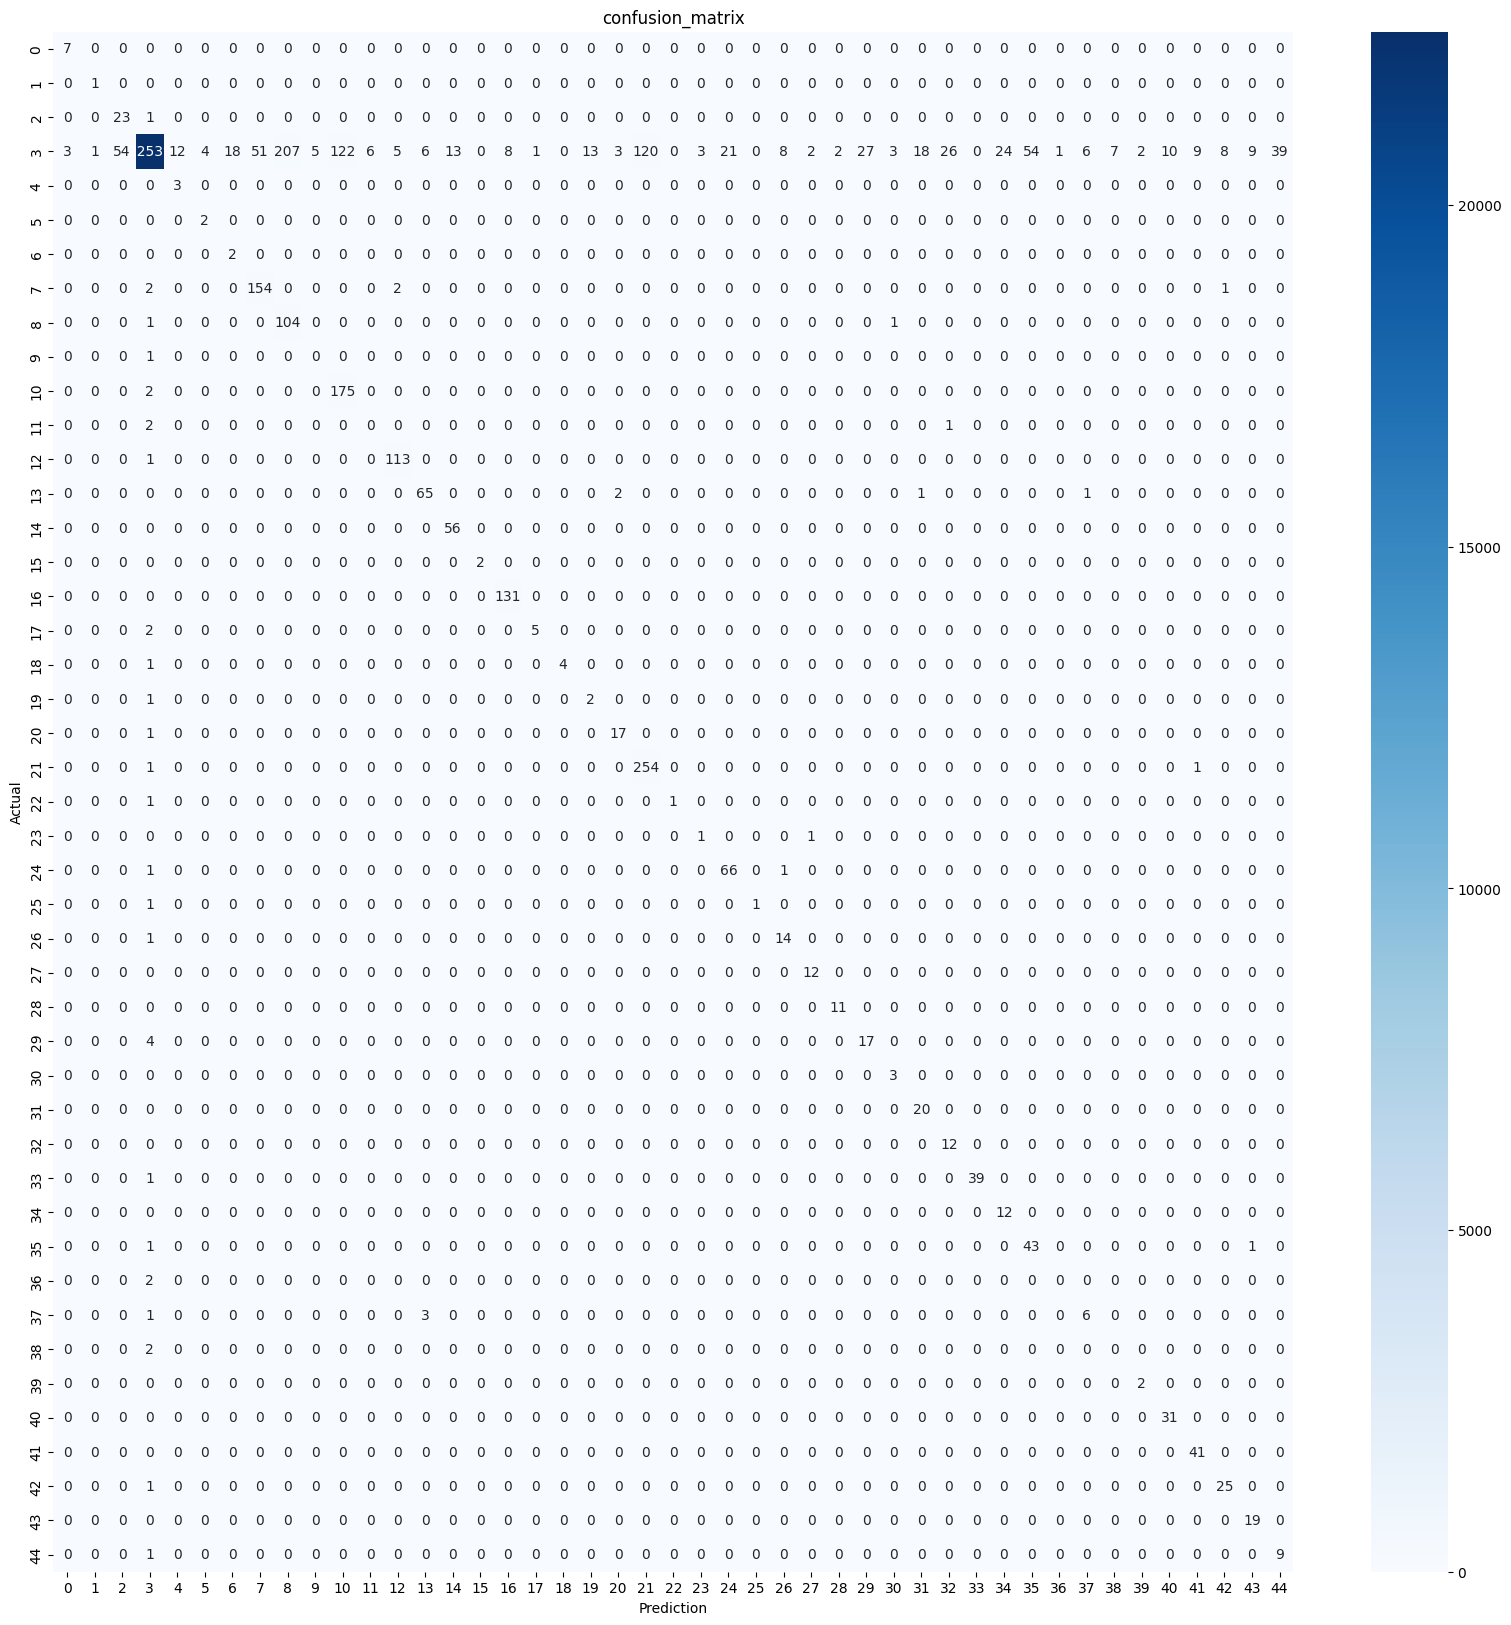

In [93]:
cm = confusion_matrix(y_test, df_ans['pred_1'])
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt='g')
plt.title('confusion_matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

### Тестовые

Произведем похожую обработку тестовых данных

In [94]:
test = pd.read_csv('test.csv', lineterminator='\n')
test.head(1)

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN


In [95]:
test['date']= pd.to_datetime(test['date'])
test['date']= test['date']-dat
test['date'] = test['date'].apply(lambda x: x.days)

In [96]:
test.shape

(55608, 15)

In [97]:
test['text_1'] = test['text'].apply(lambda x: x[:x.find('https')])

test['text_1'] = test.apply(exo, axis=1)

In [98]:
test['text_1'] = test['text_1'].apply(lambda x: x.replace('[',''))
test['text_1'] = test['text_1'].apply(lambda x: x.replace(']',''))

In [99]:
alfav = list('бвгджлпуфцчшщыэюя')

test['lg'] = test['text_1'].apply(alfa)

In [100]:
test_2 = test[test['lg']==0].copy()
test_2 =test_2.reset_index(drop=True)
test_2.shape

(9868, 17)

In [101]:
test_2['text_1'] = test_2['text_1'].apply(lambda x: 'no' if len(x)<2 else x)

In [104]:
j =0
test_f = pd.DataFrame(columns= test_2.columns)
for i in range(500,9501,500):
  data_a = test_2[j:i]
  data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
  data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x, dest='ru').text)
  test_f=pd.concat([test_f, data_a])
  print(test_f.shape)
  j=i

(500, 17)
(1000, 17)
(1500, 17)
(2000, 17)
(2500, 17)
(3000, 17)
(3500, 17)
(4000, 17)
(4500, 17)
(5000, 17)
(5500, 17)
(6000, 17)
(6500, 17)
(7000, 17)
(7500, 17)
(8000, 17)
(8500, 17)
(9000, 17)
(9500, 17)


In [105]:
data_a = test_2.loc[j:]
#data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
data_a['text_1'] = data_a['text_1'].apply(lambda x: translator.translate(x, dest='ru').text)
test_f=pd.concat([test_f, data_a])

In [106]:
test_2 =test[test['lg']==1].copy()
test = pd.concat([test_2,test_f])
test.shape

(55608, 17)

In [107]:
test['yt_channel_name'] = test['yt_channel_name'].fillna('нет')

In [108]:
j =0
test_f = pd.DataFrame(columns= test.columns)
for i in range(500,55501,500):
  data_a = test[j:i]
  data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
  data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x, dest='ru').text)
  test_f=pd.concat([test_f, data_a])
  if i%4000==0:
      print(test_f.shape)
  j=i

(4000, 17)
(8000, 17)
(12000, 17)
(16000, 17)
(20000, 17)
(24000, 17)
(28000, 17)
(32000, 17)
(36000, 17)
(40000, 17)
(44000, 17)
(48000, 17)
(52000, 17)


In [109]:
data_a = test[j:]
data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x, dest='ru').text)
data_a['yt_channel_name'] = data_a['yt_channel_name'].apply(lambda x: translator.translate(x,src='en', dest='ru').text)
test_f=pd.concat([test_f, data_a])

In [110]:
test=test_f.copy()

In [111]:
test['text_1'] = test['text_1']+' '+test['yt_channel_name']

In [112]:
for doc in tqdm(range(100)):
    test['text_2'] = test['text_1'].apply(lambda x: token(x))
test.head()

  0%|          | 0/100 [00:00<?, ?it/s]

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language,text_1,lg,text_2
0,4682,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN,пять маленьких монстров хэллоуин рифмы потеш...,1,"[пять, маленьких, монстров, хэллоуин, рифмы, п..."
2,4562,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлен...,1,"[Кто, Последний, ПЕРЕСТАНЕТ, Ехать, Выиграл, Ч..."
3,3860,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN,Мультики про машинки и паровозики для детей. Р...,1,"[Мультики, про, машинки, паровозики, для, дете..."
4,4841,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Дарг,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,1,"[СЛИШКОМ, МАЛЕНЬКИЙ, ПОРТАЛ, ЭНД, МАЙНКРАФТ, Т..."
6,4544,Ювик с планеты Ю Все серии сразу сборник 15 ...,7HPiAOD9P3o,https://www.youtube.com/watch?v=7HPiAOD9P3o,[Ювик с планеты Ю Все серии сразу сборник 15...,1572.0,0.0,none,UC6Df49Wle_y7PhDCZlBv5nw,Теремок School,https://youtube.com/channel/UC6Df49Wle_y7PhDCZ...,Мультфильмы,0.0,0.0,NaN,Ювик с планеты Ю Все серии сразу сборник 15 ...,1,"[Ювик, планеты, Все, серии, сразу, сборник, ра..."


In [113]:
j =0
test_f = pd.DataFrame(columns= test.columns)
for i in range(500,55501,500):
  data_a = test[j:i]
  data_a['text_2'] = data_a['text_2'].apply(lambda x: token_2(x))
  test_f=pd.concat([test_f, data_a])
  if i%2000==0:
      print(test_f.shape)
  j=i


(2000, 18)
(4000, 18)
(6000, 18)
(8000, 18)
(10000, 18)
(12000, 18)
(14000, 18)
(16000, 18)
(18000, 18)
(20000, 18)
(22000, 18)
(24000, 18)
(26000, 18)
(28000, 18)
(30000, 18)
(32000, 18)
(34000, 18)
(36000, 18)
(38000, 18)
(40000, 18)
(42000, 18)
(44000, 18)
(46000, 18)
(48000, 18)
(50000, 18)
(52000, 18)
(54000, 18)


In [114]:
data_a = test[j:]
data_a['text_2'] = data_a['text_2'].apply(lambda x: token_2(x))
test_f=pd.concat([test_f, data_a])

In [115]:
test_f.shape

(55608, 18)

In [116]:
test = test_f.copy()

In [117]:
test['text_2'] = test['text_2'].apply(lambda x: ' '.join(x))

In [118]:
test = test[['yt_reel_id','date','seconds', 'is_shorts', 'broadcast','yt_channel_type',
       'flag_closed', 'international', 'text_2']]
test.head()

,yt_reel_id,date,seconds,is_shorts,broadcast,yt_channel_type,flag_closed,international,text_2
0,RBw4j0aMWyM,4682,960.0,0.0,none,Детские,0.0,0.0,пять маленький монстр хэллоуин рифма потёшка д...
2,Fd9YA-oDjSo,4562,1599.0,0.0,none,Блогеры,0.0,0.0,последний перестать ехать выиграть челлендж сс...
3,NXCHY_J-5v0,3860,467.0,0.0,none,Детские,0.0,0.0,мультик машинка паровозик ребёнок развивать иг...
4,XM-GRekoYzs,4841,364.0,0.0,none,Блогеры,0.0,0.0,слишком маленький портал энд майнкрафт игрок т...
6,7HPiAOD9P3o,4544,1572.0,0.0,none,Мультфильмы,0.0,0.0,ювика планета всё серия сразу сборник развиват...


In [119]:
list_object = ['is_shorts', 'flag_closed', 'international']
test[list_object] = test[list_object].astype('object')

In [120]:
test['is_shorts'] = test['is_shorts'].apply(lambda x:str(x))
test['flag_closed'] = test['flag_closed'].apply(lambda x:str(x))
test['international'] = test['international'].apply(lambda x:str(x))

In [121]:
test['is_shorts'] = test['is_shorts'].apply(lambda x:None if x=='nan' else x)
test['flag_closed'] = test['flag_closed'].apply(lambda x:None if x=='nan' else x)
test['international'] = test['international'].apply(lambda x:None if x=='nan' else x)

In [122]:
test['broadcast'] = test['broadcast'].apply(lambda x:None if x=='none' else x)
test['yt_channel_type'] = test['yt_channel_type'].apply(lambda x:None if x=='Shorts' else x)

Сделаем предсказание на тесте и сохраним результат.

In [129]:
df_pred = test[['yt_reel_id']]

In [130]:
pred0 = mod[0].predict(test)
pred0 = label.inverse_transform(pred0)
pred1 = mod[1].predict(test)
pred1 = label.inverse_transform(pred1)
pred2 = mod[2].predict(test)
pred2 = label.inverse_transform(pred2)

In [131]:
df_pred['pred_1'] =pred0
df_pred['pred_2'] =pred1
df_pred['pred_3'] =pred2
df_pred['cartoon'] = df_pred[['pred_1','pred_2','pred_3']].mode(axis =1)[0]
df_pred.head()

,yt_reel_id,pred_1,pred_2,pred_3,cartoon
0,RBw4j0aMWyM,none,none,none,none
2,Fd9YA-oDjSo,none,none,none,none
3,NXCHY_J-5v0,none,none,none,none
4,XM-GRekoYzs,none,none,none,none
6,7HPiAOD9P3o,none,none,none,none


In [133]:
df_pred = df_pred[['yt_reel_id','cartoon']]
df_pred.head()

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
6,7HPiAOD9P3o,none


In [ ]:
df_pred.to_csv('final_5.csv', index=False)